In [44]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
from astropy.cosmology import FlatLambdaCDM
from astropy import units as U
from scipy.constants import c
import sys
from math import pi
from astropy.cosmology import FlatLambdaCDM 
from matplotlib.animation import FuncAnimation
from tqdm import tqdm

current_path = os.getcwd()
parent_dir = os.path.dirname(current_path)
print("Current working directory:", current_path)
print("Path to the parent directory:",parent_dir)

Current working directory: /home/sannino/ALMASim/experimental
Path to the parent directory: /home/sannino/ALMASim


In [45]:
def get_band_range(band):
    if band == 1:
        return (31, 45)
    elif band == 2:
        return (67, 90)
    elif band == 3:
        return (84, 116)
    elif band == 4:
        return (125, 163)
    elif band == 5:
        return (163, 211)
    elif band == 6:
        return (211, 275)
    elif band == 7:
        return (275, 373)
    elif band == 8:
        return (385, 500)
    elif band == 9:
        return (602, 720)
    elif band == 10:
        return (787, 950)

def get_band_central_freq(band):
    """
    Takes as input the band number and returns its central frequency in GHz
    """
    if band == 1:
        return 38
    elif band == 2:
        return 78.5
    elif band == 3:
        return 100
    elif band == 4:
        return  143
    elif band == 5:
        return  217
    elif band == 6:
        return 250
    elif band == 7:
        return 353
    elif band == 8:
        return 545
    elif band == 9:
        return 650
    elif band == 10:
        return 850

In [46]:
def read_line_emission_csv(path_line_emission_csv, sep=";"):
    """
    Read the csv file in which are stored the line emission's rest frequency.
    
    Parameter: 
    path_line_emission_csv (str): Path to file.csv within there are the line emission's rest frequency.
    
    Return:
    pd.DataFrame : Dataframe with line names and rest frequencies.
    """
    db_line = pd.read_csv(path_line_emission_csv, sep = sep)
    return db_line


In [47]:
def cont_finder(cont_frequencies,line_frequency):
    #cont_frequencies=sed['GHz'].values
    distances = np.abs(cont_frequencies - np.ones(len(cont_frequencies))*line_frequency)
    return np.argmin(distances)

In [48]:
def normalize_sed(sed, lum_infrared, solid_angle, cont_sens, freq_min, freq_max):
    so_to_erg_s = 3.846e+33 # Solar luminosity to erg/s -XX
    lum_infrared_erg_s = lum_infrared * so_to_erg_s  # luminosity in erg/s -XX
    sed['Jy'] = lum_infrared_erg_s * sed['erg/s/Hz'] * 1e+23 / solid_angle
    cont_mask = (sed['GHz'] >= freq_min) & (sed['GHz'] <= freq_max)
    cont_fluxes = sed[cont_mask]['Jy'].values
    min_ = np.min(cont_fluxes)
    print('Minimum continum flux: {:.2e}'.format(min_))
    print('Continum sensitivity: {:.2e}'.format(cont_sens))
    lum_save = lum_infrared
    while min_ > cont_sens:
        lum_infrared -= 0.1 * lum_infrared
        lum_infrared_erg_s = so_to_erg_s * lum_infrared
        sed['Jy'] = lum_infrared_erg_s * sed['erg/s/Hz'] * 1e+23 / solid_angle
        cont_mask = (sed['GHz'] >= freq_min) & (sed['GHz'] <= freq_max)
        cont_fluxes = sed[cont_mask]['Jy'].values
        min_ = np.min(cont_fluxes)
    
    if lum_save != lum_infrared:
        print('To match the desired SNR, luminosity has been set to {:.2e}'.format(lum_infrared))
    return sed, lum_infrared_erg_s, lum_infrared

def sed_reading(type_, path, cont_sens, freq_min, freq_max, lum_infrared=None, redshift=None):
    cosmo = FlatLambdaCDM(H0=70 * U.km / U.s / U.Mpc, Tcmb0=2.725 * U.K, Om0=0.3)
    if type_ == "extended" or type_ == 'diffuse' or type_ == 'galaxy-zoo':
        file_path = os.path.join(path, 'SED_low_z_warm_star_forming_galaxy.dat')
        if redshift is None:
            redshift = 10**(-4)
        if lum_infrared is None: 
            lum_infrared = 1e+12 # luminosity in solar luminosities
    elif type_ == "point" or type_ == "gaussian":
        file_path = os.path.join(path, 'SED_low_z_type2_AGN.dat')
        if redshift is None:
            redshift = 0.05
        if lum_infrared is None:
            lum_infrared = 1e+12 # luminosity in solar luminosities
    else:
        return "Not valid type"
    # L (erg/s/Hz) = 4 pi d^2(cm) * 10^-23 Flux (Jy)
    #  Flux (Jy) =L (erg/s/Hz) * 10^23 /  * 4 pi d^2(cm)
    # To normalize we multiply by lum_infrared_jy
    distance_Mpc = cosmo.luminosity_distance(redshift).value # distance in Mpc
    Mpc_to_cm = 3.086e+24 # Mpc to cm
    distance_cm = distance_Mpc * Mpc_to_cm # distance in cm  -XX
    solid_angle = 4 * pi  * distance_cm**2 # solid angle in cm^2 -XX
    # Load the SED
    sed = pd.read_csv(file_path, sep="\s+")
    # Convert to GHz
    sed['GHz'] = sed['um'].apply(lambda x: (x* U.um).to(U.GHz, equivalencies=U.spectral()).value)
    # Re normalize the SED and convert to Jy from erg/s/Hz
    sed, lum_infrared_erg_s, lum_infrared = normalize_sed(sed, lum_infrared, solid_angle, cont_sens, freq_min, freq_max)
    #  Flux (Jy) =L (erg/s/Hz) * 10^23 /  * 4 pi d^2(cm)
    flux_infrared = lum_infrared_erg_s * 1e+23 / solid_angle # Jy * Hz 
    #flux_infrared_jy = flux_infrared  / (sed['GHz'].values * U.GHz).to(U.Hz).value  # Jy
    sed.drop(columns=['um', 'erg/s/Hz'], inplace=True)
    sed = sed.sort_values(by='GHz', ascending=True) 
    return sed, flux_infrared, lum_infrared

In [49]:
def process_spectral_data(type_, master_path, redshift, central_frequency, delta_freq, 
    source_frequency, n_channels, lum_infrared, cont_sens, line_names=None, n_lines=None):
    """
    Process spectral data based on the type of source, wavelength conversion,
    line ratios, and given frequency bands.
    
    Prameters:
    
    redshift: Redshift value to adjust the spectral lines and cont.
    central_frequency: Central frequency of the observation band (GHz).
    delta_freq: Bandwidth around the central frequency (GHz).
    source_frequency: Frequency of the source obtained from metadata (GHz).
    lines: Optional list of line names provided by the user.
    n_lines: Number of additional lines to consider if lines is None.

    Output:


    """
    # Define the frequency range based on central frequency and bandwidth
    freq_min = central_frequency - delta_freq / 2
    freq_max = central_frequency + delta_freq / 2
    freq_step = delta_freq / n_channels
    save_freq_min = freq_min
    save_freq_max = freq_max
    start_redshift = redshift
    # Example data: Placeholder for cont and lines from SED processing
    sed, flux_infrared, lum_infrared = sed_reading(type_,os.path.join(master_path,'brightnes'), cont_sens, freq_min, freq_max, lum_infrared)
    # Placeholder for line data: line_name, observed_frequency (GHz), line_ratio, line_error
    db_line = read_line_emission_csv(os.path.join(master_path,'brightnes','temporary_update.csv'), sep=',')
    # Shift the cont and line frequencies by (1 + redshift)
    sed['GHz'] = sed['GHz'] / (1 + redshift)
    filtered_lines = db_line.copy()
    filtered_lines.drop(filtered_lines.index, inplace=True)
    if line_names is None:
        if n_lines != None:
            n = n_lines
        else:
            n = 1
    else:
        n = len(line_names)

    fwhms = [np.random.randint(3, 10) for i in range(n)]
    fwhms_freq = fwhms * U.GHz * freq_step
    max_fwhm = np.max(fwhms_freq)
    pbar = tqdm(desc='Searching lines....', total=n)
    initial_len = len(filtered_lines)
    while len(filtered_lines) < n:
        r_len = len(filtered_lines)
        filtered_lines = db_line.copy()
        filtered_lines.drop(filtered_lines.index, inplace=True)
        db_line['shifted_freq(GHz)'] = db_line['freq(GHz)'] / (1 + redshift)
        line_mask = (db_line['shifted_freq(GHz)'].astype(float) - max_fwhm >= freq_min) & (db_line['shifted_freq(GHz)'].astype(float) + max_fwhm <= freq_max)
        filtered_lines = db_line[line_mask]
        if len(filtered_lines) < n:
            n_possible = (db_line['shifted_freq(GHz)'].astype(float) + max_fwhm <= freq_max).sum() + (db_line['shifted_freq(GHz)'].astype(float) - max_fwhm >= freq_min).sum()
            ##if n_possible != 0:
            #    redshift += 0.01
            #freq_min -= freq_min / 10
            #freq_max += freq_max / 10
            redshift += 0.01
            #print(n_possible)
        #pbar.set_description("Increasing Redshift{}".format(redshift))
        if len(filtered_lines) > r_len:
            pbar.update(1)   
        recorded_length = len(filtered_lines)
    pbar.update(1) 
    pbar.close()
    if redshift != start_redshift:
        print('Redshift increased to match the desired number of lines.')
    #if len(filtered_lines) > initial_len:
    #    print('Warning: Bandwidth increased to match the desired number of lines.')
    #    increment = freq_max - save_freq_max
    #    freq_max += increment
    #    freq_min -= increment
    #    print('New Bandwidth: {} GHz'.format(round(freq_max - freq_min, 3)))
    #req_max += freq_max / 10      
    if type(line_names) == list or isinstance(line_names, np.ndarray):
        user_lines = filtered_lines[np.isin(filtered_lines['Line'], line_names)]
        if len(user_lines) != len(line_names):
            print('Warning: Selected lines do not fall in the provided band, automaticaly computing most probable lines.')
            # Find rows in filtered_lines that are not already in user_lines
            additional_lines = filtered_lines[~filtered_lines.index.isin(user_lines.index)]
            # Add rows from filtered_lines to user_lines until the length matches len(line_names)
            num_additional_rows = len(line_names) - len(user_lines)
            additional_lines = additional_lines.iloc[:num_additional_rows]  # Ensure we only select the required number of rows
            # Add additional_lines to user_lines
            user_lines = pd.concat([user_lines, additional_lines])
            filtered_lines = user_lines
        else:
            filtered_lines = user_lines
    print('Injecting {} lines'.format(len(filtered_lines)))
    filtered_lines['distance'] = np.abs(filtered_lines['shifted_freq(GHz)'].astype(float) - source_frequency)
    filtered_lines.sort_values(by='distance', inplace=True)
    cont_mask = (sed['GHz'] >= freq_min) & (sed['GHz'] <= freq_max)
    cont_fluxes = sed[cont_mask]['Jy'].values
    cont_frequencies = sed[cont_mask]['GHz'].values
    if n_lines != None:
        if n_lines > len(filtered_lines):
            print(f'Warning: Cant insert {n_lines}, injecting {len(filtered_lines)}.')
        else:
            filtered_lines = filtered_lines.head(n_lines)
    line_names = filtered_lines['Line'].values
    cs = filtered_lines['c'].values
    cdeltas = filtered_lines['err_c'].values
    line_ratios = np.array([np.random.normal(c, cd) for c, cd in zip(cs, cdeltas)])
    # Get the index of the continuum where the line fall
    #line_indexes = filtered_lines['shifted_freq(GHz)'].apply(lambda x: cont_finder(cont_frequencies, float(x)))
    # Line Flux (integrated over the line) = Cont_flux + 10^(log(L_infrared / line_width_in_Hz) + c)
    line_frequencies =  filtered_lines['shifted_freq(GHz)'].values 
    line_rest_frequencies = filtered_lines['freq(GHz)'].values * U.GHz 
    new_cont_freq = np.linspace(freq_min, freq_max, n_channels)
    if len(cont_fluxes) > 1: 
        int_cont_fluxes = np.interp(new_cont_freq, cont_frequencies, cont_fluxes)
    else:
        int_cont_fluxes = np.ones(n_channels) * cont_fluxes[0]
    line_indexes = filtered_lines['shifted_freq(GHz)'].apply(lambda x: cont_finder(new_cont_freq, float(x)))
    freq_steps = np.array([new_cont_freq[line_index + fwhm] - new_cont_freq[line_index] for fwhm, line_index in zip(fwhms, line_indexes)]) * U.GHz
    freq_steps = freq_steps.to(U.Hz).value
    #line_fluxes = int_cont_fluxes[line_indexes] + (10**(np.log10(flux_infrared)  + line_ratios) / freq_steps)
    line_fluxes = 10**(np.log10(flux_infrared)  + line_ratios) / freq_steps
    line_flux_errors = (10**(np.log10(flux_infrared) + line_ratios) / freq_steps) * np.log(10) * cdeltas 
    bandwidth = freq_max - freq_min
    freq_support = bandwidth / n_channels
    return int_cont_fluxes, line_fluxes,line_flux_errors, line_names, redshift, line_frequencies, line_indexes, n_channels, bandwidth, freq_support, new_cont_freq, fwhms, lum_infrared, cs, freq_step, max_fwhm, filtered_lines

In [50]:
def luminosity_to_jy(velocity, data,  redshift):
    
        """
        This function takes as input a pandas db containing luminosities in K km s-1 pc2, redshifts, and luminosity distances in Mpc, 
        and returns the brightness values in Jy.
        
        Parameters:
        velocity (float): The velocity dispersion assumed for the line (Km s-1).
        data (pandas.DataFrame): A pandas DataFrame containing the data.
        rest_frequency (float): The rest frequency of the line in GHz. Defaults to 115.27 GHz for CO(1-0).

        Output:
        sigma: numpy.ndarray: An array of brightness values in Jy.

        """
        alpha = 3.255 * 10**7 / 10**9
        cosmo = FlatLambdaCDM(H0=70 * U.km / U.s / U.Mpc, Tcmb0=2.725 * U.K, Om0=0.3)
        # Intensity: 10^9 K km s−1 pc2
        sigma = (data['Intensity'] * ((1 + redshift)**3 * data['freq(GHz)'] **2)) / (alpha * velocity * cosmo.luminosity_distance(redshift).value**2)
        error_sigma = (data['Error']* ((1 + redshift)**3 * data['freq(GHz)'] **2))/ (alpha * velocity * cosmo.luminosity_distance(redshift).value**2)
        return sigma, error_sigma


In [53]:
type_ = 'point'
master_path = parent_dir
redshift = 0.5
band = 6
central_frequency = get_band_central_freq(band)   # in GHz
delta_freq = 40  # in GHz
source_frequency = central_frequency # in GHz
n_channels = 256
lum_infrared = 1e12  # Infrared Luminosity
cont_sens = 1e-3  # Continuum sensibility
line_names = None  # List of lines name
n_lines = None  # Number of lines
velocity = 300  # Velocity dispersion in Km s-1
freq_min = central_frequency - delta_freq / 2
freq_max = central_frequency + delta_freq / 2
# Comparison
cont_fluxes, line_fluxes, line_flux_errors, line_namess, redshift, line_frequencies, line_indexes, n_channels, bandwidth, freq_support, new_cont_freq, fwhms, lum_infrared, cs, freq_steps, max_fwhm, filtered_lines = process_spectral_data(
    type_, master_path, redshift, central_frequency, delta_freq, source_frequency, n_channels, lum_infrared, cont_sens, line_names, n_lines)
line_emission_data = pd.read_csv(os.path.join(parent_dir,'brightnes','temporary_update.csv'))
line_emission_data['shifted_freq(GHz)'] = line_emission_data['freq(GHz)'] / (1 + redshift)
line_name2=filtered_lines['Line'].values
sigma,error_sigma = luminosity_to_jy(velocity, filtered_lines, redshift)

output_file_path = os.path.join(current_path, 'luminosity_comparison.txt')

with open(output_file_path, 'w') as file:
    for i, (flux_psd, flux_lum_to_jy) in enumerate(zip(line_fluxes, sigma)):
        file.write(f"Line {line_names[i]}:\n")
        file.write(f"Line {line_name2[i]}:\n")
        file.write(f"Luminosity given by process_spectral_data: {flux_psd:.2e} Jy\n")
        file.write(f"Luminosity given by luminosity_to_jy: {flux_lum_to_jy:.2e} Jy\n")
        file.write(f"Infrared Luminosity: {lum_infrared:.2e}\n")
        file.write(f"c value: {cs[i]:.2e}\n")
        file.write(f"Frequency steps value: {freq_steps:.2e}\n")
        file.write("\n")



Minimum continum flux: 9.68e-03
Continum sensitivity: 1.00e-03
To match the desired SNR, luminosity has been set to 9.85e+10


Searching lines....: 2it [00:00, 1649.68it/s]             

Injecting 6 lines



/tmp/ipykernel_564731/2778515627.py:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_lines['distance'] = np.abs(filtered_lines['shifted_freq(GHz)'].astype(float) - source_frequency)
/tmp/ipykernel_564731/2778515627.py:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_lines.sort_values(by='distance', inplace=True)


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

Minimum continum flux: 4.32e-03
Continum sensitivity: 1.00e-03
To match the desired SNR, luminosity has been set to 2.29e+11


Searching lines....: 2it [00:00, 1727.47it/s]             

Injecting 1 lines



/tmp/ipykernel_564731/4238865280.py:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_lines['distance'] = np.abs(filtered_lines['shifted_freq(GHz)'].astype(float) - source_frequency)
/tmp/ipykernel_564731/4238865280.py:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_lines.sort_values(by='distance', inplace=True)


Minimum continum flux: 1.03e-03
Continum sensitivity: 1.00e-03
To match the desired SNR, luminosity has been set to 2.06e+11


Searching lines....: 2it [00:00, 1769.00it/s]             

Injecting 1 lines


Minimum continum flux: 9.66e-04
Continum sensitivity: 1.00e-03


Searching lines....: 2it [00:00, 1611.33it/s]             

Injecting 1 lines


Minimum continum flux: 1.01e-03
Continum sensitivity: 1.00e-03
To match the desired SNR, luminosity has been set to 1.85e+11


Searching lines....: 2it [00:00, 1129.32it/s]             

Injecting 1 lines


Minimum continum flux: 9.40e-04
Continum sensitivity: 1.00e-03


Searching lines....: 2it [00:00, 599.74it/s]              

Injecting 1 lines


Minimum continum flux: 9.72e-04
Continum sensitivity: 1.00e-03


Searching lines....: 2it [00:00, 622.39it/s]              

Injecting 1 lines


Minimum continum flux: 1.01e-03
Continum sensitivity: 1.00e-03
To match the desired SNR, luminosity has been set to 1.67e+11


Searching lines....: 2it [00:00, 1015.20it/s]             

Injecting 1 lines


Minimum continum flux: 9.32e-04
Continum sensitivity: 1.00e-03


Searching lines....: 2it [00:00, 1708.13it/s]             

Injecting 1 lines


Minimum continum flux: 9.60e-04
Continum sensitivity: 1.00e-03


Searching lines....: 2it [00:00, 520.45it/s]              

Injecting 1 lines


Minimum continum flux: 9.86e-04
Continum sensitivity: 1.00e-03


Searching lines....: 2it [00:00, 593.84it/s]              

Injecting 1 lines


Minimum continum flux: 1.01e-03
Continum sensitivity: 1.00e-03
To match the desired SNR, luminosity has been set to 1.50e+11


Searching lines....: 2it [00:00, 623.41it/s]              

Injecting 1 lines


Minimum continum flux: 9.31e-04
Continum sensitivity: 1.00e-03


Searching lines....: 2it [00:00, 1127.35it/s]             

Injecting 1 lines


Minimum continum flux: 9.52e-04
Continum sensitivity: 1.00e-03


Searching lines....: 2it [00:00, 1800.52it/s]             

Injecting 1 lines


Minimum continum flux: 9.73e-04
Continum sensitivity: 1.00e-03


Searching lines....: 2it [00:00, 539.43it/s]              

Injecting 1 lines


Minimum continum flux: 9.92e-04
Continum sensitivity: 1.00e-03


Searching lines....: 2it [00:00, 1738.93it/s]             

Injecting 1 lines


Minimum continum flux: 1.01e-03
Continum sensitivity: 1.00e-03
To match the desired SNR, luminosity has been set to 1.35e+11


Searching lines....: 2it [00:00, 538.18it/s]              

Injecting 1 lines


Minimum continum flux: 9.27e-04
Continum sensitivity: 1.00e-03


Searching lines....: 2it [00:00, 624.66it/s]              

Injecting 1 lines


Minimum continum flux: 9.43e-04
Continum sensitivity: 1.00e-03


Searching lines....: 2it [00:00, 646.42it/s]              

Injecting 1 lines


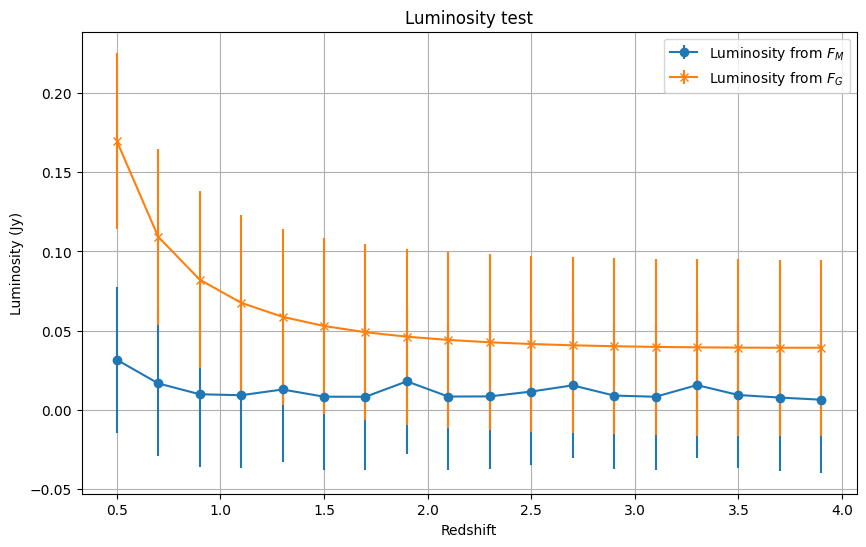

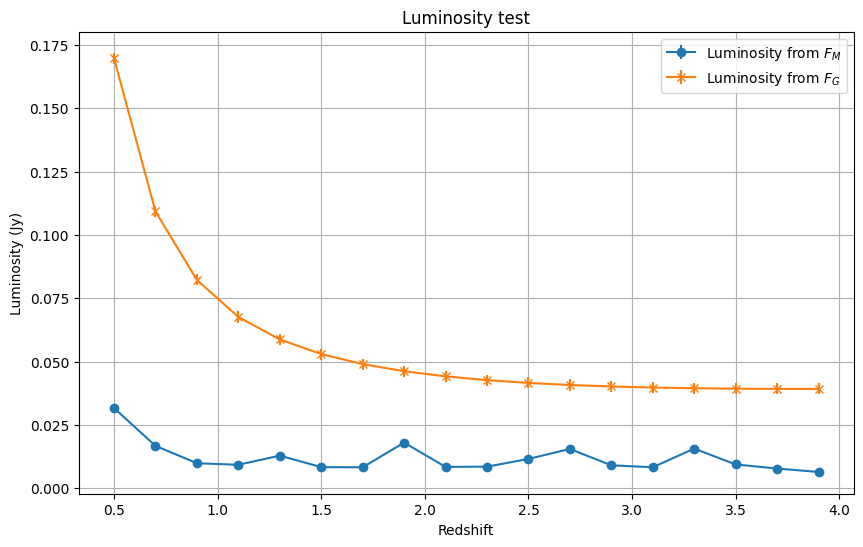

In [ ]:
type_ = 'point'
master_path = parent_dir
band = 3
central_frequency = 115  # in GHz
delta_freq = 10  # in GHz
source_frequency = central_frequency  # in GHz
n_channels = 256
lum_infrared = 1e12  # Infrared Luminosity
cont_sens = 1e-3  # Continuum sensibility
line_names = None  # List of lines name
n_lines = None  # Number of lines
velocity = 300  # Velocity dispersion in Km s-1

# Variabili per salvare i risultati
redshifts = np.arange(0.5, 4, 0.2)
luminosity_psd = []
luminosity_lum_to_jy = []
# Percorso del file CSV
path_line_emission_csv = os.path.join(master_path, 'brightnes', 'temporary_update.csv')
line_emission_data = pd.read_csv(path_line_emission_csv)

# Output file path
output_file_path = os.path.join(current_path, 'luminosity_comparison2.txt')

with open(output_file_path, 'w') as file:
    for redshift in redshifts:
        central_frequency = 115 / (1 + redshift)
        freq_min = central_frequency - delta_freq / 2
        freq_max = central_frequency + delta_freq / 2

        # Esecuzione delle funzioni
        cont_fluxes, line_fluxes, line_flux_errors,line_names, redshift, line_frequencies, line_indexes, n_channels, bandwidth, freq_support, new_cont_freq, fwhms, lum_infrared, cs, freq_steps, max_fwhm = process_spectral_data(
            type_, master_path, redshift, central_frequency, delta_freq, source_frequency, n_channels, lum_infrared, cont_sens, line_names, n_lines)

        line_emission_data['shifted_freq(GHz)'] = line_emission_data['freq(GHz)'] / (1 + redshift)
        line_mask2 = (line_emission_data['shifted_freq(GHz)'].astype(float) - max_fwhm >= freq_min) & (line_emission_data['shifted_freq(GHz)'].astype(float) + max_fwhm <= freq_max)
        filtered_lines2 = line_emission_data[line_mask2]
        line_name2 = filtered_lines2['Line'].values
        sigma,error_sigma = luminosity_to_jy(velocity, filtered_lines2, redshift)
        luminosity_psd_mean = np.mean(line_fluxes)
        luminosity_lum_to_jy_mean = np.mean(sigma)
        luminosity_psd.append(luminosity_psd_mean)
        luminosity_lum_to_jy.append(luminosity_lum_to_jy_mean)
        error_psd_plus=line_flux_errors/line_fluxes
        error_sigma_plus=error_sigma/sigma
        # Scrittura dei risultati nel file
        for i, (flux_psd, flux_lum_to_jy) in enumerate(zip(line_fluxes, sigma)):
            file.write(f"Redshift: {redshift:.1f}\n")
            file.write(f"Line {line_names[i]}:\n")
            file.write(f"Line {line_name2[i]}:\n")
            file.write(f"Luminosity given by process_spectral_data: {flux_psd:.2e} Jy\n")
            file.write(f"Luminosity given by luminosity_to_jy: {flux_lum_to_jy:.2e} Jy\n")
            file.write(f"Infrared Luminosity: {lum_infrared:.2e}\n")
            file.write(f"c value: {cs[i]:.2e}\n")
            file.write(f"Frequency steps value: {freq_steps:.2e}\n")
            file.write("\n")

plt.figure(figsize=(10, 6))
plt.errorbar(redshifts, luminosity_psd, yerr=error_psd_plus, label='Luminosity from $F_{M}$', marker='o')
plt.errorbar(redshifts, luminosity_lum_to_jy, yerr=error_sigma_plus ,label='Luminosity from $F_{G}$', marker='x')
plt.xlabel('Redshift')
plt.ylabel('Luminosity (Jy)')
plt.title('Luminosity test')
plt.legend()
plt.grid(True)
plt.savefig('luminosity_comparison_vs_redshift.png')
plt.show()
plt.figure(figsize=(10, 6))
plt.errorbar(redshifts, luminosity_psd, yerr=line_flux_errors, label='Luminosity from $F_{M}$', marker='o')
plt.errorbar(redshifts, luminosity_lum_to_jy, yerr=error_sigma ,label='Luminosity from $F_{G}$', marker='x')
plt.xlabel('Redshift')
plt.ylabel('Luminosity (Jy)')
plt.title('Luminosity test')
plt.legend()
plt.grid(True)
plt.savefig('luminosity_comparison_vs_redshift2.png')
plt.show()